In [ ]:
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Total number of images in the training set:  144
Total number of cleaned images found:        144
Total number of samples in the test set:     72


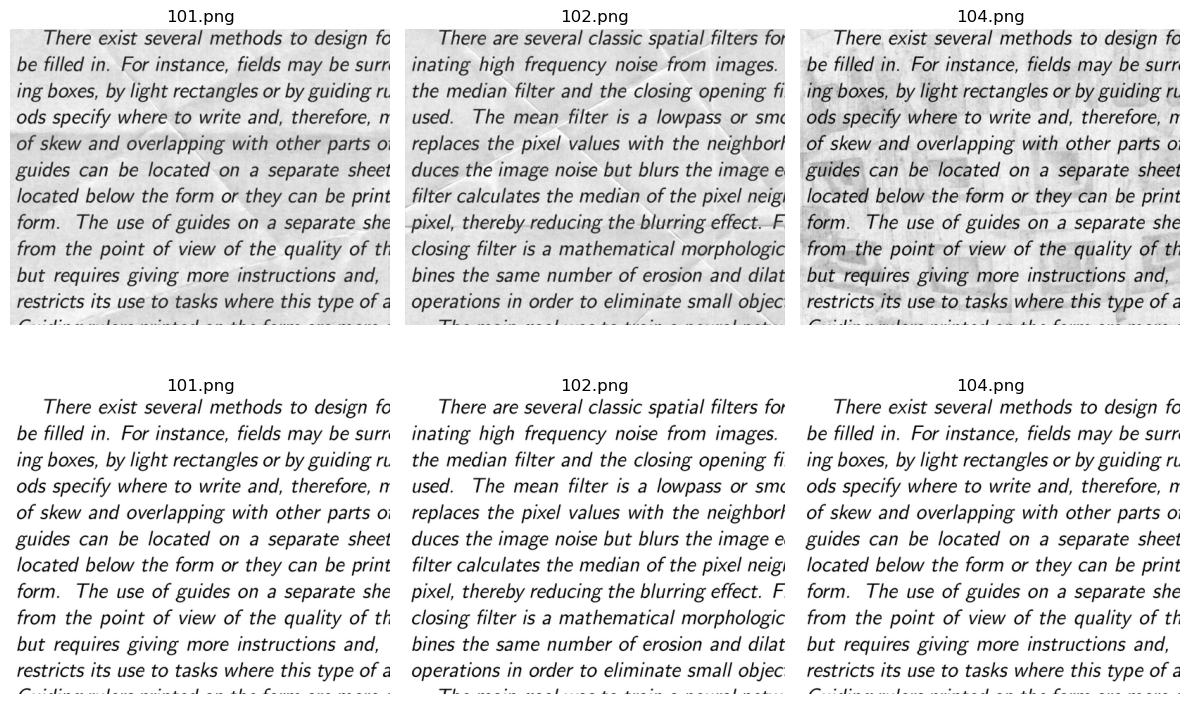

In [47]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.metrics import structural_similarity as ssim

from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.optimizers import Adagrad
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split

import tensorflow as tf

np.random.seed(111)
tf.random.set_seed(111)

# ------------------------------------------------------------------
# PATHS (ADAPTED FOR YOUR PROJECT STRUCTURE)
# ------------------------------------------------------------------
# This notebook is in:  ASSIGNMENT3-DL/question2
# Dataset is in:         ASSIGNMENT3-DL/denoising-dirty-documents

BASE_DIR = Path("..") / "denoising-dirty-documents"

# If your PNGs are one level deeper (train/train/*.png) – which your first screenshot suggests:
TRAIN_DIR = BASE_DIR / "train" / "train"
TRAIN_CLEANED_DIR = BASE_DIR / "train_cleaned" / "train_cleaned"
TEST_DIR = BASE_DIR / "test" / "test"

# If instead the images are directly in .../train/*.png, use this instead:
# TRAIN_DIR = BASE_DIR / "train"
# TRAIN_CLEANED_DIR = BASE_DIR / "train_cleaned"
# TEST_DIR = BASE_DIR / "test"

train_images = sorted(glob.glob(str(TRAIN_DIR / "*.png")))
# make sure labels follow same filenames, in the same order
train_labels = [str(TRAIN_CLEANED_DIR / os.path.basename(p)) for p in train_images]
test_images = sorted(glob.glob(str(TEST_DIR / "*.png")))

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found:       ", len(train_labels))
print("Total number of samples in the test set:    ", len(test_images))

# Quick visual sanity check
samples = train_images[:3] + train_labels[:3]
f, ax = plt.subplots(2, 3, figsize=(12, 8))
for i, img_path in enumerate(samples):
    img = imread(img_path)
    ax[i // 3, i % 3].imshow(img, cmap='gray')
    ax[i // 3, i % 3].set_title(os.path.basename(img_path))
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def build_autoencoder():
    input_img = Input(shape=(420, 540, 1), name='image_input')
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)
    
    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2')(x)
    x = UpSampling2D((2, 2), name='upsample3')(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Conv3')(x)
    
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer=Adagrad(), loss='binary_crossentropy', metrics=['mse'])
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 420, 540, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 420, 540, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 210, 270, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 210, 270, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample3 (UpSampling2D)        │ (None, 420, 540, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 420, 540, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
IMG_HEIGHT = 420
IMG_WIDTH = 540

X = []
Y = []

for img_path in train_images:
    img = load_img(img_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img).astype('float32') / 255.0
    X.append(img)

for img_path in train_labels:
    img = load_img(img_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img).astype('float32') / 255.0
    Y.append(img)

X = np.array(X)
Y = np.array(Y)
filenames = np.array([os.path.basename(p) for p in train_images])

print("Size of X (noisy) :", X.shape)
print("Size of Y (clean) :", Y.shape)


Size of X (noisy) : (144, 420, 540, 1)
Size of Y (clean) : (144, 420, 540, 1)


- Training set: 90% of the pairs
- Test set: 10%

In [51]:
TEST_SIZE = 0.1  # 10% for independent test

X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
    X, Y, filenames,
    test_size=TEST_SIZE,
    random_state=111
)

print("Total number of training samples:   ", X_train.shape[0])
print("Total number of test (independent): ", X_test.shape[0])


Total number of training samples:    129
Total number of test (independent):  15


In [52]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.cumulative_times = []
        self._start_time = None
        self.total_time = 0.0

    def on_epoch_begin(self, epoch, logs=None):
        import time
        self._epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        import time
        t = time.time() - self._epoch_start
        self.epoch_times.append(t)
        self.total_time += t
        self.cumulative_times.append(self.total_time)

time_callback = TimeHistory()


In [53]:
EPOCHS = 100
BATCH_SIZE = 8
autoencoder = build_autoencoder()
history = autoencoder.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[time_callback],
    verbose=1
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 548ms/step - loss: 0.6244 - mse: 0.1887 - val_loss: 0.5912 - val_mse: 0.1703
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - loss: 0.5675 - mse: 0.1608 - val_loss: 0.5416 - val_mse: 0.1464
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - loss: 0.5200 - mse: 0.1383 - val_loss: 0.4979 - val_mse: 0.1261
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step - loss: 0.4783 - mse: 0.1193 - val_loss: 0.4601 - val_mse: 0.1095
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 575ms/step - loss: 0.4429 - mse: 0.1042 - val_loss: 0.4292 - val_mse: 0.0967
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 570ms/step - loss: 0.4145 - mse: 0.0928 - val_loss: 0.4047 - val_mse: 0.0874
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - loss: 0.3919 - mse: 0.0845 - val_loss: 0.3856 - val_mse: 0.0807
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 536ms/step - loss: 0.3743 - mse: 0.0786 - val_loss: 0.3710 - val_mse: 0.0761
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 5

In [ ]:
# Predict on the independent test set
y_pred = autoencoder.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

mse_list = []
ssim_list = []
file_list = []

for i in range(len(X_test)):
    pred = y_pred[i].squeeze()      # (H, W)
    target = y_test[i].squeeze()    # (H, W)

    mse_val = np.mean((pred - target) ** 2)
    ssim_val = ssim(target, pred, data_range=1.0)  # images are in [0,1]

    mse_list.append(mse_val)
    ssim_list.append(ssim_val)
    file_list.append(fn_test[i])

metrics_df = pd.DataFrame({
    "filename": file_list,
    "mse": mse_list,
    "ssim": ssim_list
})

# metrics_df.to_csv("denoising_autoencoder_test_metrics.csv", index=False)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F3795764D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


In [55]:
print(metrics_df.head().round({'mse': 4, 'ssim': 4}))
print("\nOverall Test Metrics:")
print("Mean MSE  :", f"{metrics_df['mse'].mean():.4f}")
print("Std  MSE  :", f"{metrics_df['mse'].std():.4f}")
print("Mean SSIM :", f"{metrics_df['ssim'].mean():.4f}")
print("Std  SSIM :", f"{metrics_df['ssim'].std():.4f}")


  filename     mse    ssim
0   38.png  0.0673  0.4718
1   60.png  0.0555  0.5405
2   92.png  0.0522  0.5276
3   56.png  0.0564  0.5327
4  137.png  0.0583  0.5918

Overall Test Metrics:
Mean MSE  : 0.0622
Std  MSE  : 0.0088
Mean SSIM : 0.4967
Std  SSIM : 0.0430


In [56]:
# Extract history
train_mse = history.history['mse']
test_mse = history.history['val_mse']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

times = time_callback.cumulative_times  # same length as number of epochs
epochs = np.arange(1, len(train_mse) + 1)


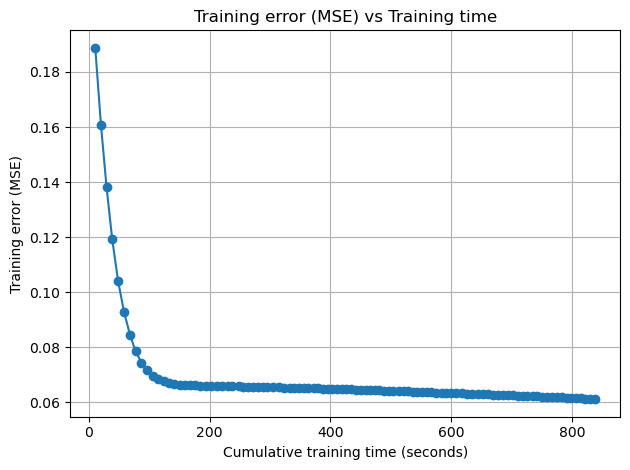

In [57]:
plt.figure()
plt.plot(times, train_mse, marker='o')
plt.xlabel("Cumulative training time (seconds)")
plt.ylabel("Training error (MSE)")
plt.title("Training error (MSE) vs Training time")
plt.grid(True)
plt.tight_layout()
plt.show()


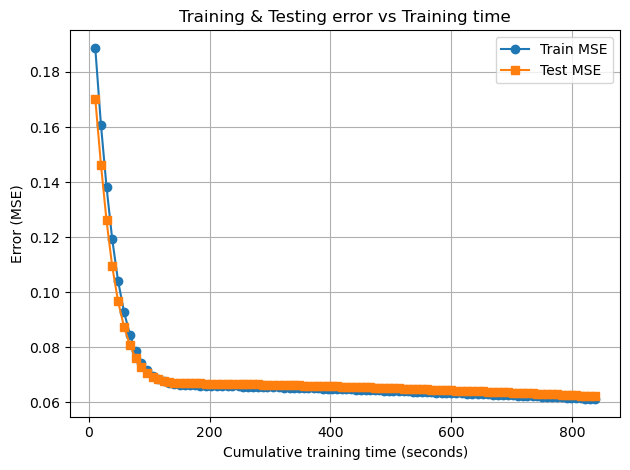

In [58]:
plt.figure()
plt.plot(times, train_mse, marker='o', label='Train MSE')
plt.plot(times, test_mse, marker='s', label='Test MSE')
plt.xlabel("Cumulative training time (seconds)")
plt.ylabel("Error (MSE)")
plt.title("Training & Testing error vs Training time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


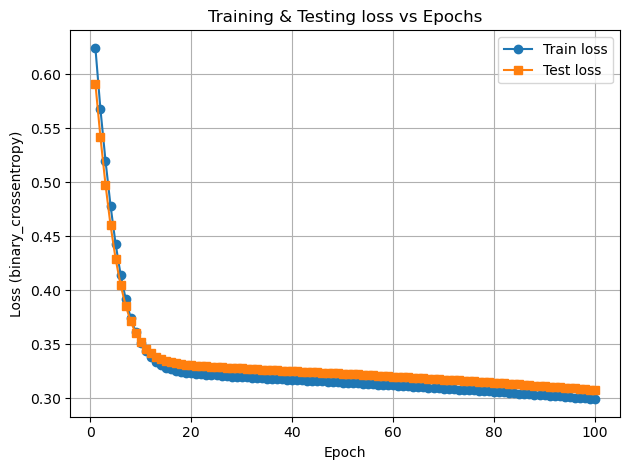

In [ ]:
plt.figure()
plt.plot(epochs, train_loss, marker='o', label='Train loss')
plt.plot(epochs, test_loss, marker='s', label='Test loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (binary_crossentropy)")
plt.title("Training & Testing loss vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Example test image: ..\denoising-dirty-documents\test\test\124.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


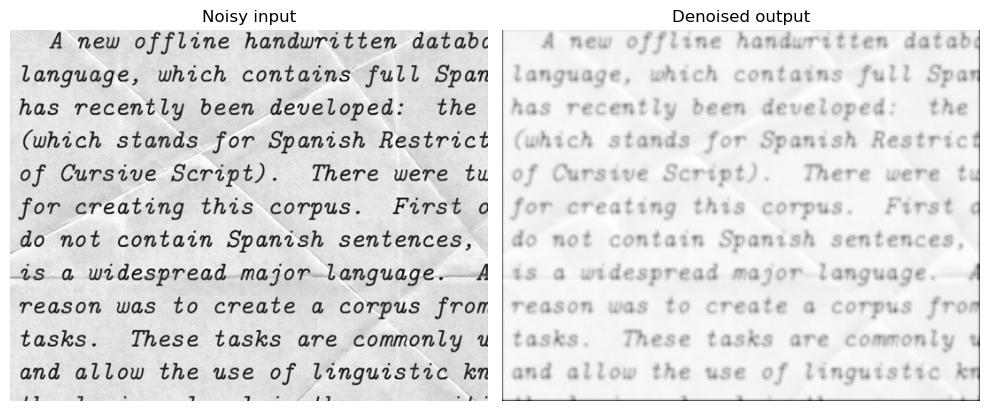

In [60]:
idx = 10  # pick an index inside range(len(test_images))
test_path = test_images[idx]
print("Example test image:", test_path)

sample_test = load_img(test_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
sample_test_arr = img_to_array(sample_test).astype('float32') / 255.0
sample_test_arr = np.expand_dims(sample_test_arr, axis=0)

predicted = autoencoder.predict(sample_test_arr)[0]

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_test_arr.squeeze(), cmap='gray')
ax[0].set_title("Noisy input")
ax[0].axis('off')

ax[1].imshow(predicted.squeeze(), cmap='gray')
ax[1].set_title("Denoised output")
ax[1].axis('off')

plt.tight_layout()
plt.show()
